#### Importing Libraries

In [460]:
import sys
sys.path.append('../')
import pandas as pd
from src.utils import check_missing_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#### Loading Data

In [461]:
df_data = pd.read_csv('../data/data.csv')

In [462]:
df_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [463]:
print(df_data.columns)

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')


#### Data Quality Assessemnt

In [464]:
check_missing_data(df_data)

'Success: No missing values.'

#### Calculating RFMS Metrics

- Recency (R): The number of days since the customer's last transaction.
- Frequency (F): The total number of transactions made by the customer.
- Monetary (M): The total value of transactions made by the customer.
- Stability (S): The consistency of transactions over time. This can be measured using the standard deviation of the transaction values over time.

In [465]:
df_data['TransactionStartTime'] = pd.to_datetime(df_data['TransactionStartTime'])

In [466]:
max_date = df_data['TransactionStartTime'].max()
print(max_date)

2019-02-13 10:01:28+00:00


In [467]:
min_date = df_data['TransactionStartTime'].min()
print(min_date)

2018-11-15 02:18:49+00:00


In [468]:
# Calculate Recency
recency_df = df_data.groupby('CustomerId')['TransactionStartTime'].max().reset_index()
recency_df['Recency'] = (max_date - recency_df['TransactionStartTime']).dt.days
recency_df.drop('TransactionStartTime', axis=1, inplace=True)

In [469]:
recency_df.head()

,CustomerId,Recency
0,CustomerId_1,83
1,CustomerId_10,83
2,CustomerId_1001,89
3,CustomerId_1002,25
4,CustomerId_1003,11


In [470]:
print(len(recency_df))

3742


In [471]:
check_missing_data(recency_df)

'Success: No missing values.'

In [472]:
# Calculate Frequency
frequency_df = df_data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency_df.columns = ['CustomerId', 'Frequency']

In [473]:
frequency_df.head()

,CustomerId,Frequency
0,CustomerId_1,1
1,CustomerId_10,1
2,CustomerId_1001,5
3,CustomerId_1002,11
4,CustomerId_1003,6


In [474]:
check_missing_data(frequency_df)

'Success: No missing values.'

In [475]:
# Calculate Monetary
monetary_df = df_data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary_df.columns = ['CustomerId', 'Monetary']

In [476]:
monetary_df.head()

,CustomerId,Monetary
0,CustomerId_1,-10000.0
1,CustomerId_10,-10000.0
2,CustomerId_1001,20000.0
3,CustomerId_1002,4225.0
4,CustomerId_1003,20000.0


In [477]:
check_missing_data(monetary_df)

'Success: No missing values.'

In [478]:
# Calculate Stability
stability_df = df_data.groupby('CustomerId')['Amount'].std().reset_index()
stability_df.columns = ['CustomerId', 'Stability']

In [479]:
stability_df.head()

,CustomerId,Stability
0,CustomerId_1,NaN
1,CustomerId_10,NaN
2,CustomerId_1001,6558.963333
3,CustomerId_1002,560.498966
4,CustomerId_1003,6030.478146


In [480]:
check_missing_data(stability_df)

,Column Name,Missing Values,Percentage Missing
1,Stability,712,19.027258


In [481]:
# data cleaning
stability_df['Stability'].fillna(0, inplace=True)

C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_26860\1829478075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stability_df['Stability'].fillna(0, inplace=True)


In [482]:
check_missing_data(stability_df)

'Success: No missing values.'

In [483]:
# Merge RFMS dataframes
rfms_df = recency_df.merge(frequency_df, on='CustomerId')
rfms_df = rfms_df.merge(monetary_df, on='CustomerId')
rfms_df = rfms_df.merge(stability_df, on='CustomerId')

In [484]:
rfms_df.head()

,CustomerId,Recency,Frequency,Monetary,Stability
0,CustomerId_1,83,1,-10000.0,0.000000
1,CustomerId_10,83,1,-10000.0,0.000000
2,CustomerId_1001,89,5,20000.0,6558.963333
3,CustomerId_1002,25,11,4225.0,560.498966
4,CustomerId_1003,11,6,20000.0,6030.478146


In [485]:
check_missing_data(rfms_df)

'Success: No missing values.'

#### RFMS correlations

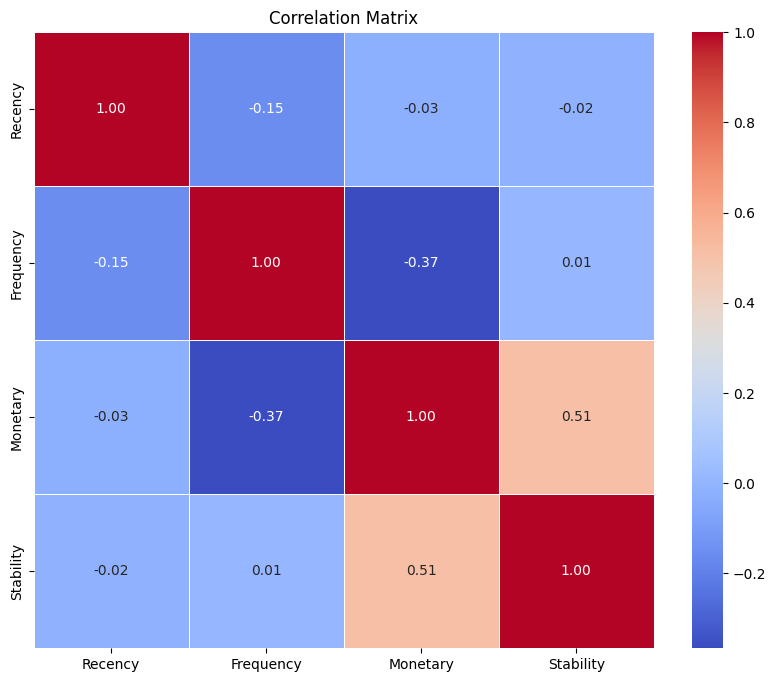

In [486]:
selected_columns = ['Recency', 'Frequency', 'Monetary', 'Stability']
correlation_matrix = rfms_df[selected_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### High and Low RFMS Scores

In [487]:
# clusters (2 for good and bad)
kmeans = KMeans(n_clusters=2, random_state=42)
rfms_df['Cluster'] = kmeans.fit_predict(rfms_df[['Recency', 'Frequency', 'Monetary', 'Stability']])

cluster_centers = kmeans.cluster_centers_
print(cluster_centers)

rfms_df['Label'] = rfms_df['Cluster'].map({0: 'High', 1: 'Low'})

[[3.04693768e+01 2.54974592e+01 1.19864583e+05 1.22551212e+04]
 [2.03333333e+01 1.09000000e+02 6.48229827e+07 1.69621118e+06]]


In [488]:
rfms_df.head()

,CustomerId,Recency,Frequency,Monetary,Stability,Cluster,Label
0,CustomerId_1,83,1,-10000.0,0.000000,0,High
1,CustomerId_10,83,1,-10000.0,0.000000,0,High
2,CustomerId_1001,89,5,20000.0,6558.963333,0,High
3,CustomerId_1002,25,11,4225.0,560.498966,0,High
4,CustomerId_1003,11,6,20000.0,6030.478146,0,High


In [489]:
count_good = rfms_df['Label'].value_counts()['High']
print(count_good)

3739


In [490]:
count_bad = rfms_df['Label'].value_counts()['Low']
print(count_bad)

3


#### Perform WoE Binning

In [491]:
# Calculate WoE and IV
def calculate_woe_iv(data, feature, target):
    # Create bins
    data['Bin'] = pd.qcut(data[feature], q=5, duplicates='drop')
    
    # Group by bins
    grouped = data.groupby('Bin')
    
    # Calculate WoE and IV
    woe_iv_df = pd.DataFrame()
    woe_iv_df['Low'] = grouped[target].sum()
    woe_iv_df['High'] = grouped[target].count() - woe_iv_df['Low']
    woe_iv_df['Total'] = woe_iv_df['Low'] + woe_iv_df['High']
    woe_iv_df['Distribution Low'] = woe_iv_df['Low'] / woe_iv_df['Low'].sum()
    woe_iv_df['Distribution High'] = woe_iv_df['High'] / woe_iv_df['High'].sum()
    woe_iv_df['WoE'] = np.log(woe_iv_df['Distribution Low'] / woe_iv_df['Distribution High'])
    woe_iv_df['IV'] = (woe_iv_df['Distribution Low'] - woe_iv_df['Distribution High']) * woe_iv_df['WoE']
    woe_iv_df = woe_iv_df.replace([np.inf, -np.inf], 0)
    
    IV = woe_iv_df['IV'].sum()
    
    return woe_iv_df, IV

In [492]:
woe_iv_df, iv = calculate_woe_iv(rfms_df, 'Recency', 'Cluster')
print(woe_iv_df)
print(f'Information Value (IV): {iv}')

               Low  High  Total  Distribution Low  Distribution High  \
Bin                                                                    
(-0.001, 4.0]    1   872    873          0.333333           0.233217   
(4.0, 14.0]      1   648    649          0.333333           0.173308   
(14.0, 34.0]     0   747    747          0.000000           0.199786   
(34.0, 57.8]     1   723    724          0.333333           0.193367   
(57.8, 90.0]     0   749    749          0.000000           0.200321   

                    WoE        IV  
Bin                                
(-0.001, 4.0]  0.357172  0.035759  
(4.0, 14.0]    0.654070  0.104668  
(14.0, 34.0]   0.000000  0.000000  
(34.0, 57.8]   0.544552  0.076219  
(57.8, 90.0]   0.000000  0.000000  
Information Value (IV): 0.2166450033309648


C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_26860\425566259.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Bin')
c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [493]:
woe_iv_df, iv = calculate_woe_iv(rfms_df, 'Frequency', 'Cluster')
print(woe_iv_df)
print(f'Information Value (IV): {iv}')

                Low  High  Total  Distribution Low  Distribution High  \
Bin                                                                     
(0.999, 2.0]      0   962    962          0.000000           0.257288   
(2.0, 5.0]        0   666    666          0.000000           0.178122   
(5.0, 10.0]       1   658    659          0.333333           0.175983   
(10.0, 26.0]      0   711    711          0.000000           0.190158   
(26.0, 4091.0]    2   742    744          0.666667           0.198449   

                     WoE        IV  
Bin                                 
(0.999, 2.0]    0.000000  0.000000  
(2.0, 5.0]      0.000000  0.000000  
(5.0, 10.0]     0.638756  0.100509  
(10.0, 26.0]    0.000000  0.000000  
(26.0, 4091.0]  1.211759  0.567367  
Information Value (IV): 0.667875876591499


C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_26860\425566259.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Bin')
c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [494]:
woe_iv_df, iv = calculate_woe_iv(rfms_df, 'Monetary', 'Cluster')
print(woe_iv_df)
print(f'Information Value (IV): {iv}')

                          Low  High  Total  Distribution Low  \
Bin                                                            
(-104900000.001, 2000.0]    0   785    785               0.0   
(2000.0, 13976.0]           0   712    712               0.0   
(13976.0, 38946.8]          0   748    748               0.0   
(38946.8, 100282.8]         0   748    748               0.0   
(100282.8, 83451240.0]      3   746    749               1.0   

                          Distribution High       WoE        IV  
Bin                                                              
(-104900000.001, 2000.0]           0.209949  0.000000  0.000000  
(2000.0, 13976.0]                  0.190425  0.000000  0.000000  
(13976.0, 38946.8]                 0.200053  0.000000  0.000000  
(38946.8, 100282.8]                0.200053  0.000000  0.000000  
(100282.8, 83451240.0]             0.199519  1.611848  1.290254  
Information Value (IV): 1.290254262957113


C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_26860\425566259.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Bin')
c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [495]:
woe_iv_df, iv = calculate_woe_iv(rfms_df, 'Stability', 'Cluster')
print(woe_iv_df)
print(f'Information Value (IV): {iv}')

                         Low  High  Total  Distribution Low  \
Bin                                                           
(-0.001, 1620.679]         0  1497   1497               0.0   
(1620.679, 5478.04]        0   748    748               0.0   
(5478.04, 7626.707]        0   809    809               0.0   
(7626.707, 3309916.124]    3   685    688               1.0   

                         Distribution High       WoE        IV  
Bin                                                             
(-0.001, 1620.679]                0.400374  0.000000  0.000000  
(1620.679, 5478.04]               0.200053  0.000000  0.000000  
(5478.04, 7626.707]               0.216368  0.000000  0.000000  
(7626.707, 3309916.124]           0.183204  1.697155  1.386229  
Information Value (IV): 1.3862290078971033


C:\Users\abraham.shimelis\AppData\Local\Temp\ipykernel_26860\425566259.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Bin')
c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Modeling

In [496]:
rfms_df.head()

,CustomerId,Recency,Frequency,Monetary,Stability,Cluster,Label,Bin
0,CustomerId_1,83,1,-10000.0,0.000000,0,High,"(-0.001, 1620.679]"
1,CustomerId_10,83,1,-10000.0,0.000000,0,High,"(-0.001, 1620.679]"
2,CustomerId_1001,89,5,20000.0,6558.963333,0,High,"(5478.04, 7626.707]"
3,CustomerId_1002,25,11,4225.0,560.498966,0,High,"(-0.001, 1620.679]"
4,CustomerId_1003,11,6,20000.0,6030.478146,0,High,"(5478.04, 7626.707]"


##### Risk Probability Model

In [497]:
df_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [498]:
rfms_df.head()

,CustomerId,Recency,Frequency,Monetary,Stability,Cluster,Label,Bin
0,CustomerId_1,83,1,-10000.0,0.000000,0,High,"(-0.001, 1620.679]"
1,CustomerId_10,83,1,-10000.0,0.000000,0,High,"(-0.001, 1620.679]"
2,CustomerId_1001,89,5,20000.0,6558.963333,0,High,"(5478.04, 7626.707]"
3,CustomerId_1002,25,11,4225.0,560.498966,0,High,"(-0.001, 1620.679]"
4,CustomerId_1003,11,6,20000.0,6030.478146,0,High,"(5478.04, 7626.707]"


##### Scaling the data

In [499]:
# Separate features and target variable
X_data = rfms_df.drop(['Cluster', 'Label', 'CustomerId', 'Bin'], axis=1)
y_data = rfms_df['Cluster']

In [500]:
# Split data for training and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [501]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [502]:
# Split training data for training and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

##### Model Training and Evaluation

In [503]:
# Create a pipeline with a Random Forest Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [504]:
# Train the model
pipeline.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [505]:
# Evaluate model
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_score:.2f}')

ROC AUC Score: 0.67


c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


##### Model Training and Evaluation

In [506]:
# Create a pipeline with Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

In [507]:
# Train the model
pipeline.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))])

In [508]:
# Evaluate model
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_score:.2f}')

ROC AUC Score: 0.53


c:\Users\abraham.shimelis\10-academy\kaim\Bati-Bank\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


##### Credit Score Model

##### Loan Amount and Duration Model